# **Zip files**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import zipfile
from PIL import Image
from tqdm import tqdm
from google.colab import drive

In [ ]:
# Mount Google Drive if needed
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

Google Drive is already mounted.


In [ ]:
# Paths setup
zip_path = '/content/drive/MyDrive/AJP images/All images after augmentation_23k.zip'
output_csv = '/content/drive/MyDrive/AJP images/image_metrics.csv'
temp_extract_dir = '/content/temp_extract'

# Create temporary directory
os.makedirs(temp_extract_dir, exist_ok=True)

In [ ]:
# Pixel to micron conversion
pixel_to_micron = 100 / 205  # Conversion factor

def process_image(image_path, original_name):
    """Process a single image and return metrics dictionary"""
    metrics = {"Image": original_name}  # Use the original name from zip

    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('L')
        width, height = image.size

        # Crop to square
        min_dim = min(width, height)
        if width < height:
            top = (height - min_dim) // 2
            bottom = top + min_dim
            left, right = 0, min_dim
        else:
            left = (width - min_dim) // 2
            right = left + min_dim
            top, bottom = 0, min_dim

        image = image.crop((left, top, right, bottom))
        image_array = np.array(image)

        # Image processing
        A = np.array(image)
        B = np.ones_like(A) * 255
        C = B - A

        # Thresholding
        _, thresholded = cv2.threshold(C, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Contour detection
        contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            raise ValueError("No contours found")

        # Separate contours
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        central_line_contour = contours[0]
        overspray_contours = contours[1:] if len(contours) > 1 else []

        # Create mask images
        central_line_image = np.zeros_like(thresholded)
        cv2.drawContours(central_line_image, [central_line_contour], -1, 255, thickness=cv2.FILLED)
        overspray_image = np.zeros_like(thresholded)
        cv2.drawContours(overspray_image, overspray_contours, -1, 255, thickness=cv2.FILLED)

        # Calculate metrics
        central_line_points = central_line_contour[:, 0, :]
        y_coords = np.unique(central_line_points[:, 1])
        widths = [
            np.ptp(central_line_points[central_line_points[:, 1] == y, 0])
            for y in y_coords
            if len(central_line_points[central_line_points[:, 1] == y, 0]) > 1
        ]
        average_line_width = np.mean(widths) if widths else np.nan

        # Edge roughness calculation
        M = cv2.moments(central_line_contour)
        centroid_x = int(M['m10'] / M['m00']) if M['m00'] != 0 else 0
        edges = cv2.Canny(central_line_image, 100, 200)
        edge_coords = np.column_stack(np.where(edges > 0))

        left_edge_coords = edge_coords[edge_coords[:, 1] < centroid_x]
        right_edge_coords = edge_coords[edge_coords[:, 1] >= centroid_x]

        nominal_line_left = np.mean(left_edge_coords[:, 1]) if left_edge_coords.size > 0 else np.nan
        nominal_line_right = np.mean(right_edge_coords[:, 1]) if right_edge_coords.size > 0 else np.nan

        distances_left = left_edge_coords[:, 1] - nominal_line_left if left_edge_coords.size > 0 else np.array([])
        distances_right = right_edge_coords[:, 1] - nominal_line_right if right_edge_coords.size > 0 else np.array([])

        rms_edge_roughness = np.sqrt(np.mean(np.concatenate((distances_left, distances_right)) ** 2)) if distances_left.size + distances_right.size > 0 else np.nan

        # Additional metrics
        uniformity = np.std(widths) if widths else np.nan
        central_line_area = np.sum(central_line_image > 0)
        overspray_area = np.sum(overspray_image > 0)
        total_area = thresholded.shape[0] * thresholded.shape[1]

        overspray_percentage = (overspray_area / (total_area - central_line_area)) * 100 if central_line_area < total_area else np.nan
        overspray_ratio_to_lw = (overspray_area / central_line_area) * 100 if central_line_area > 0 else np.nan

        x_coords = np.unique(central_line_points[:, 0])
        max_line_length = np.max([
            np.ptp(central_line_points[central_line_points[:, 0] == x, 1])
            for x in x_coords
            if len(central_line_points[central_line_points[:, 0] == x, 1]) > 1
        ]) if x_coords.size else np.nan

        total_line_pixels = np.sum(central_line_image > 0)
        discontinuous_pixels = total_line_pixels - max_line_length
        discontinuity_percent = (discontinuous_pixels / total_line_pixels) * 100 if total_line_pixels > 0 else np.nan

        # Overspray statistics
        overspray_areas = [cv2.contourArea(c) for c in overspray_contours]
        mean_overspray_area = np.mean(overspray_areas) if overspray_areas else np.nan
        std_overspray_area = np.std(overspray_areas) if overspray_areas else np.nan

        # Convert overspray area to μm²
        mean_overspray_area_um2 = mean_overspray_area * (pixel_to_micron ** 2) if not np.isnan(mean_overspray_area) else np.nan
        std_overspray_area_um2 = std_overspray_area * (pixel_to_micron ** 2) if not np.isnan(std_overspray_area) else np.nan

        center_x_px = np.mean(central_line_points[:, 0])
        num_overspray_left = sum(1 for c in overspray_contours if np.mean(c[:, 0, 0]) < center_x_px)
        num_overspray_right = sum(1 for c in overspray_contours if np.mean(c[:, 0, 0]) > center_x_px)
        total_num_overspray = len(overspray_contours)

        # Final metrics assembly
        metrics.update({
            "Line Type": "Continuous" if max_line_length >= 0.95 * min_dim else "Discontinuous",
            "Average Line Width (μm)": average_line_width * pixel_to_micron,
            "RMS Edge Roughness (μm)": rms_edge_roughness * pixel_to_micron,
            "Overspray Percentage (%)": overspray_percentage,
            "Overspray Ratio to LW (%)": overspray_ratio_to_lw,
            "Vertical Max Pixel Value": max_line_length,
            "Continuity Percentage (%)": discontinuity_percent,
            "Mean Overspray Area (px²)": mean_overspray_area,
            "Std. Overspray Area (px²)": std_overspray_area,
            "Mean Overspray Area (μm²)": mean_overspray_area_um2,
            "Std. Overspray Area (μm²)": std_overspray_area_um2,
            "Count of Overspray (Left)": num_overspray_left,
            "Count of Overspray (Right)": num_overspray_right,
            "Total Number of Overspray": total_num_overspray,
        })

    except Exception as e:
        metrics["Error"] = str(e)

    return metrics

# Process images directly from zip while preserving original names
metrics_list = []
with zipfile.ZipFile(zip_path) as z:
    # Get all image files
    image_files = [f for f in z.namelist() if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for file in tqdm(image_files, desc="Processing images"):
        try:
            # Extract to temporary location
            temp_path = z.extract(file, temp_extract_dir)

            # Process with original name
            metrics = process_image(temp_path, os.path.basename(file))
            metrics_list.append(metrics)

            # Remove temporary file
            os.remove(temp_path)

        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            continue

# Save results to CSV
df = pd.DataFrame(metrics_list)
df.to_csv(output_csv, index=False)
print(f"Processing complete. Metrics saved to {output_csv}")

# Clean up temp directory
if os.path.exists(temp_extract_dir):
    for root, dirs, files in os.walk(temp_extract_dir, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))
    os.rmdir(temp_extract_dir)

Processing images: 100%|██████████| 23367/23367 [14:53<00:00, 26.14it/s]


Processing complete. Metrics saved to /content/drive/MyDrive/AJP images/image_metrics.csv


# Batches

In [ ]:
# Import necessary libraries
import cv2
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import glob

In [ ]:
from google.colab import drive

# Check if drive is already mounted
if not os.path.exists('/content/drive'):
  # Mount Google Drive if not already mounted
  drive.mount('/content/drive')
else:
  print("Google Drive is already mounted.")

Mounted at /content/drive


In [ ]:
# Input and output folder paths
#Shihab's folder
input_folder = "/content/drive/MyDrive/AJP images/Random/generated/ATM23_CR9_FR15_PS2"
output_folder = "/content/drive/MyDrive/AJP images/Random/generated/ATM23_CR9_FR15_PS2"

#ERIk can put the folder name below making my folder name as comment with #
#input_folder = "/content/drive/MyDrive/PSI Project/LTRIMAGES2"
#output_folder = "/content/drive/MyDrive/PSI Project/LTRIMAGES2"

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get all image file paths from the input folder
image_paths = glob.glob(os.path.join(input_folder, "*.png"))  # Use glob.glob() correctly

# Print the number of images found
print(f"Found {len(image_paths)} images.")

Found 60 images.


In [ ]:
#Shihab's output folder
output_csv = "/content/drive/MyDrive/AJP images/Random/generated/ATM23_CR9_FR15_PS2/A23_C9_F15_P2_metrics.csv"

pixel_to_micron = 100 / 205  # Conversion factor

def process_image(image_path):
    """Process a single image and return metrics dictionary"""
    metrics = {"Image": os.path.basename(image_path)}

    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('L')
        width, height = image.size

        # Crop to square
        min_dim = min(width, height)
        if width < height:
            top = (height - min_dim) // 2
            bottom = top + min_dim
            left, right = 0, min_dim
        else:
            left = (width - min_dim) // 2
            right = left + min_dim
            top, bottom = 0, min_dim

        image = image.crop((left, top, right, bottom))
        image_array = np.array(image)

        # Image processing
        A = np.array(image)
        B = np.ones_like(A) * 255
        C = B - A

        # Thresholding
        _, thresholded = cv2.threshold(C, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Contour detection
        contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            raise ValueError("No contours found")

        # Separate contours
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        central_line_contour = contours[0]
        overspray_contours = contours[1:] if len(contours) > 1 else []

        # Create mask images
        central_line_image = np.zeros_like(thresholded)
        cv2.drawContours(central_line_image, [central_line_contour], -1, 255, thickness=cv2.FILLED)
        overspray_image = np.zeros_like(thresholded)
        cv2.drawContours(overspray_image, overspray_contours, -1, 255, thickness=cv2.FILLED)

        # Calculate metrics
        central_line_points = central_line_contour[:, 0, :]
        y_coords = np.unique(central_line_points[:, 1])
        widths = [
            np.ptp(central_line_points[central_line_points[:, 1] == y, 0])
            for y in y_coords
            if len(central_line_points[central_line_points[:, 1] == y, 0]) > 1
        ]
        average_line_width = np.mean(widths) if widths else np.nan

        # Edge roughness calculation
        M = cv2.moments(central_line_contour)
        centroid_x = int(M['m10'] / M['m00']) if M['m00'] != 0 else 0
        edges = cv2.Canny(central_line_image, 100, 200)
        edge_coords = np.column_stack(np.where(edges > 0))

        left_edge_coords = edge_coords[edge_coords[:, 1] < centroid_x]
        right_edge_coords = edge_coords[edge_coords[:, 1] >= centroid_x]

        nominal_line_left = np.mean(left_edge_coords[:, 1]) if left_edge_coords.size > 0 else np.nan
        nominal_line_right = np.mean(right_edge_coords[:, 1]) if right_edge_coords.size > 0 else np.nan

        distances_left = left_edge_coords[:, 1] - nominal_line_left if left_edge_coords.size > 0 else np.array([])
        distances_right = right_edge_coords[:, 1] - nominal_line_right if right_edge_coords.size > 0 else np.array([])

        rms_edge_roughness = np.sqrt(np.mean(np.concatenate((distances_left, distances_right)) ** 2)) if distances_left.size + distances_right.size > 0 else np.nan

        # Additional metrics
        uniformity = np.std(widths) if widths else np.nan
        central_line_area = np.sum(central_line_image > 0)
        overspray_area = np.sum(overspray_image > 0)
        total_area = thresholded.shape[0] * thresholded.shape[1]

        overspray_percentage = (overspray_area / (total_area - central_line_area)) * 100 if central_line_area < total_area else np.nan
        overspray_ratio_to_lw = (overspray_area / central_line_area) * 100 if central_line_area > 0 else np.nan

        x_coords = np.unique(central_line_points[:, 0])
        max_line_length = np.max([
            np.ptp(central_line_points[central_line_points[:, 0] == x, 1])
            for x in x_coords
            if len(central_line_points[central_line_points[:, 0] == x, 1]) > 1
        ]) if x_coords.size else np.nan

        total_line_pixels = np.sum(central_line_image > 0)
        discontinuous_pixels = total_line_pixels - max_line_length
        discontinuity_percent = (discontinuous_pixels / total_line_pixels) * 100 if total_line_pixels > 0 else np.nan

        # Overspray statistics
        overspray_areas = [cv2.contourArea(c) for c in overspray_contours]
        mean_overspray_area = np.mean(overspray_areas) if overspray_areas else np.nan
        std_overspray_area = np.std(overspray_areas) if overspray_areas else np.nan

        # Convert overspray area to μm²
        mean_overspray_area_um2 = mean_overspray_area * (pixel_to_micron ** 2) if not np.isnan(mean_overspray_area) else np.nan
        std_overspray_area_um2 = std_overspray_area * (pixel_to_micron ** 2) if not np.isnan(std_overspray_area) else np.nan

        center_x_px = np.mean(central_line_points[:, 0])
        num_overspray_left = sum(1 for c in overspray_contours if np.mean(c[:, 0, 0]) < center_x_px)
        num_overspray_right = sum(1 for c in overspray_contours if np.mean(c[:, 0, 0]) > center_x_px)
        total_num_overspray = len(overspray_contours)

        # Final metrics assembly
        metrics.update({
            "Line Type": "Continuous" if max_line_length >= 0.95 * min_dim else "Discontinuous",
            "Average Line Width (px)": average_line_width,
            "Average Line Width (μm)": average_line_width * pixel_to_micron,
            "RMS Edge Roughness (px)": rms_edge_roughness,
            "RMS Edge Roughness (μm)": rms_edge_roughness * pixel_to_micron,
            "Uniformity (px)": uniformity,
            "Uniformity (μm)": uniformity * pixel_to_micron,
            "Overspray Percentage (%)": overspray_percentage,
            "Overspray Ratio to LW (%)": overspray_ratio_to_lw,
            "Vertical Max Pixel Value": max_line_length,
            "Continuity Percentage (%)": discontinuity_percent,
            "Mean Overspray Area (px²)": mean_overspray_area,
            "Std. Overspray Area (px²)": std_overspray_area,
            "Mean Overspray Area (μm²)": mean_overspray_area_um2,
            "Std. Overspray Area (μm²)": std_overspray_area_um2,
            "Count of Overspray (Left)": num_overspray_left,
            "Count of Overspray (Right)": num_overspray_right,
            "Total Number of Overspray": total_num_overspray,
        })

    except Exception as e:
        metrics["Error"] = str(e)

    return metrics


#Erik' output folder
#output_csv = "/content/drive/MyDrive/PSI Project/LTRIMAGES/testmetrics2.csv"


        # Main processing loop
image_files = [f for f in os.listdir(input_folder)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

metrics_list = []
for filename in tqdm(image_files, desc="Processing images"):
    image_path = os.path.join(input_folder, filename)
    metrics = process_image(image_path)
    if "Error" in metrics:
        print(f"Error processing {filename}: {metrics['Error']}")
    else:
        metrics_list.append(metrics)

# Save results to CSV
df = pd.DataFrame(metrics_list)
df.to_csv(output_csv, index=False)
print(f"Processing complete. Metrics saved to {output_csv}")

Processing images:   0%|          | 0/60 [00:00<?, ?it/s]

Processing complete. Metrics saved to /content/drive/MyDrive/AJP images/Random/generated/ATM23_CR9_FR15_PS2/A23_C9_F15_P2_metrics.csv


# **Single image**

Please upload an image:


Saving ATM23_CR9_FR5_PS2_T2.png to ATM23_CR9_FR5_PS2_T2.png
Image cropped to (1536, 1536) with coordinates: left=256, top=0, right=1792, bottom=1536
Extracted Focusing Ratio (FR): 5.0


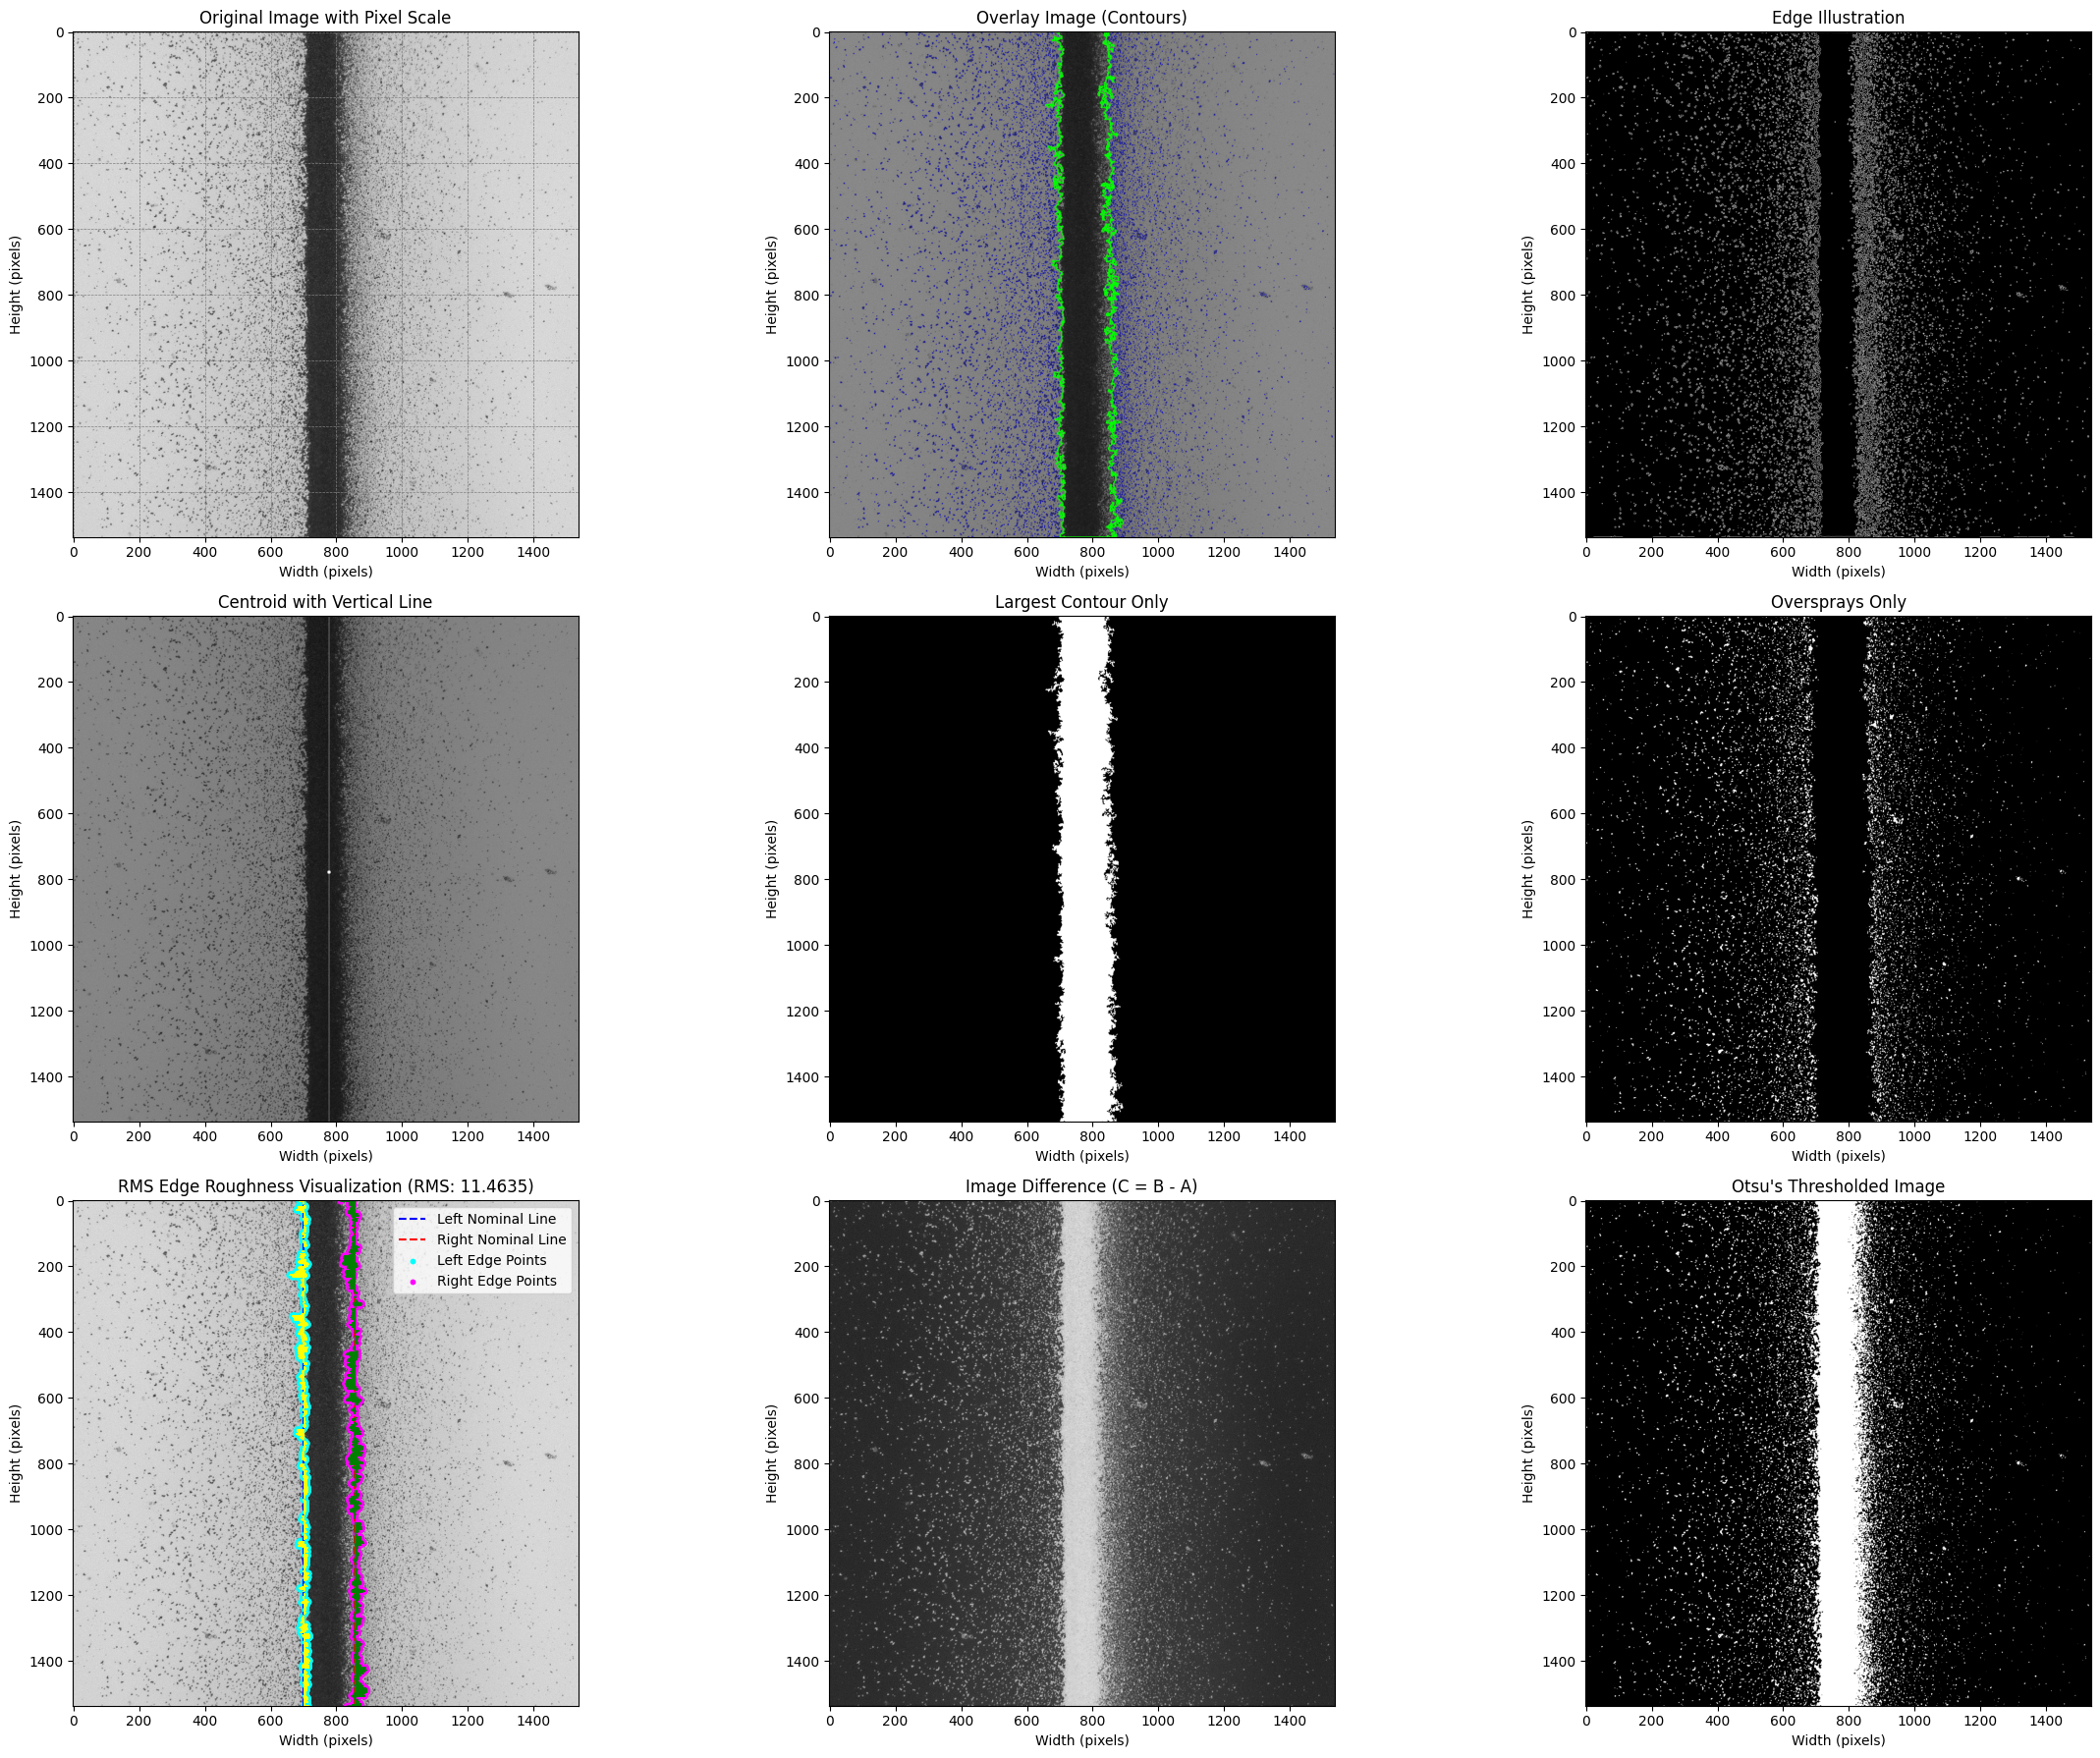


--- Metrics ---
Image: ATM23_CR9_FR5_PS2_T2.png
Line Type: Continuous
Average Line Width (px): 124.84691546077684
Average Line Width (μm): 60.90093437111065
RMS Edge Roughness (px): 11.4635440859704
RMS Edge Roughness (μm): 5.591972724863609
Uniformity (px): 64.63547224755024
Uniformity (μm): 31.52949865734158
Overspray Percentage (%): 4.375892101238995
Overspray Ratio to LW (%): 39.02059688944935
Vertical Max Pixel Value: 1534
Aerosol Jet Diameter (μm): 138.73287910650933
LW to Aerosol Jet Diameter: 2.2780090410619303
Continuity Percentage (%): 99.3551912568306
Mean Overspray Area (px²): 6.492087799897907
Std. Overspray Area (px²): 11.135889772325678
Mean Overspray Area (μm²): 1.5448156573225238
Std. Overspray Area (μm²): 2.6498250499287748
Count of Overspray (Left): 4036
Count of Overspray (Right): 3800
Total Number of Overspray: 7836
Furthest Overspray Left (px): 0
Furthest Overspray Left (μm): 0.0
Furthest Overspray Right (px): 1533
Furthest Overspray Right (μm): 747.8048780487804

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
from google.colab import files
from tqdm import tqdm
import matplotlib.pyplot as plt
import re

# Define the pixel-to-micron conversion factor
pixel_to_micron = 100 / 205  # 205 pixels = 100 microns

# Function to display images with pixel scale
def show_image(title, image, cmap='gray'):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.show()

# Step 1: Upload a single image from your device
print("Please upload an image:")
uploaded_file = files.upload()

# Get the uploaded file name
uploaded_image_path = next(iter(uploaded_file.keys()))

try:
    # Load the image and check dimensions
    image = Image.open(uploaded_image_path).convert('L')  # Convert to grayscale
    width, height = image.size

    # Updated image cropping logic
    # Find the smaller dimension and compute cropping coordinates
    min_dim = min(width, height)
    if width < height:
        # Crop height to match width (center the crop)
        top = (height - min_dim) // 2
        bottom = top + min_dim
        left, right = 0, min_dim
    else:
        # Crop width to match height (center the crop)
        left = (width - min_dim) // 2
        right = left + min_dim
        top, bottom = 0, min_dim

    # Perform cropping
    image = image.crop((left, top, right, bottom))
    image_array = np.array(image)
    print(f"Image cropped to {image.size} with coordinates: left={left}, top={top}, right={right}, bottom={bottom}")

    # Step 2: Prepare the image for contour analysis
    A = np.array(image)
    B = np.ones_like(A) * 255
    C = B - A

    # Step 3: Apply Otsu's thresholding
    _, thresholded = cv2.threshold(C, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 4: Detect contours
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        raise ValueError("No contours found")

    # Separate central line and overspray
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    central_line_contour = contours[0]
    overspray_contours = contours[1:] if len(contours) > 1 else []

    # Draw contours for visualization
    central_line_image = np.zeros_like(thresholded)
    cv2.drawContours(central_line_image, [central_line_contour], -1, 255, thickness=cv2.FILLED)
    overspray_image = np.zeros_like(thresholded)
    cv2.drawContours(overspray_image, overspray_contours, -1, 255, thickness=cv2.FILLED)

    # Step 5: Metrics calculation
    # (a) Average Line Width (vertical spread) in pixels
    central_line_points = central_line_contour[:, 0, :]
    y_coords = np.unique(central_line_points[:, 1])
    widths = [
        np.ptp(central_line_points[central_line_points[:, 1] == y, 0])
        for y in y_coords
        if len(central_line_points[central_line_points[:, 1] == y, 0]) > 1
    ]
    average_line_width = np.mean(widths) if widths else np.nan

    # (b) RMS Edge Roughness (in pixels) - Updated Calculation
    # Step 1: Calculate the centroid of the largest contour
    M = cv2.moments(central_line_contour)
    centroid_x = int(M['m10'] / M['m00']) if M['m00'] != 0 else 0

    # Step 2: Extract edge coordinates
    edges = cv2.Canny(central_line_image, 100, 200)
    edge_coords = np.column_stack(np.where(edges > 0))

    # Step 3: Separate edge coordinates into left and right based on centroid
    left_edge_coords = edge_coords[edge_coords[:, 1] < centroid_x]
    right_edge_coords = edge_coords[edge_coords[:, 1] >= centroid_x]

    # Step 4: Calculate nominal lines (mean x-coordinates)
    nominal_line_left = np.mean(left_edge_coords[:, 1]) if left_edge_coords.size > 0 else np.nan
    nominal_line_right = np.mean(right_edge_coords[:, 1]) if right_edge_coords.size > 0 else np.nan

    # Step 5: Calculate distances to nominal lines
    distances_left = left_edge_coords[:, 1] - nominal_line_left if left_edge_coords.size > 0 else np.array([])
    distances_right = right_edge_coords[:, 1] - nominal_line_right if right_edge_coords.size > 0 else np.array([])

    # Step 6: Calculate RMS Edge Roughness
    rms_edge_roughness = np.sqrt(np.mean(np.concatenate((distances_left, distances_right)) ** 2)) if distances_left.size + distances_right.size > 0 else np.nan

    # (c) Uniformity in pixels
    uniformity = np.std(widths) if widths else np.nan

    # (d) Overspray Percentage
    central_line_area = np.sum(central_line_image > 0)
    overspray_area = np.sum(overspray_image > 0)
    total_area = thresholded.shape[0] * thresholded.shape[1]
    overspray_percentage = (
        (overspray_area / (total_area - central_line_area)) * 100
        if central_line_area < total_area
        else np.nan
    )

    # (e) Overspray Ratio to Line Width (LW)
    overspray_ratio_to_lw = (
        (overspray_area / central_line_area) * 100
        if central_line_area > 0
        else np.nan
    )

    # (f) Vertical Max Pixel Value
    x_coords = np.unique(central_line_points[:, 0])
    max_line_length = np.max([
        np.ptp(central_line_points[central_line_points[:, 0] == x, 1])
        for x in x_coords
        if len(central_line_points[central_line_points[:, 0] == x, 1]) > 1
    ]) if x_coords.size else np.nan

    # (g) Calculate discontinuity percentage
    total_line_pixels = np.sum(central_line_image > 0)
    discontinuous_pixels = total_line_pixels - max_line_length
    discontinuity_percent = (discontinuous_pixels / total_line_pixels) * 100 if total_line_pixels > 0 else np.nan

    # (h) Calculate overspray areas and statistics
    overspray_areas = [cv2.contourArea(c) for c in overspray_contours]
    mean_overspray_area = np.mean(overspray_areas) if overspray_areas else np.nan
    std_overspray_area = np.std(overspray_areas) if overspray_areas else np.nan

    # Convert overspray area to μm²
    mean_overspray_area_um2 = mean_overspray_area * (pixel_to_micron ** 2) if not np.isnan(mean_overspray_area) else np.nan
    std_overspray_area_um2 = std_overspray_area * (pixel_to_micron ** 2) if not np.isnan(std_overspray_area) else np.nan

    # (i) Count overspray on left and right sides of the central line
    center_x_px = np.mean(central_line_points[:, 0])
    num_overspray_left = sum(
        1 for c in overspray_contours if np.mean(c[:, 0, 0]) < center_x_px
    )
    num_overspray_right = sum(
        1 for c in overspray_contours if np.mean(c[:, 0, 0]) > center_x_px
    )
    total_num_overspray = len(overspray_contours)

    # (j) Calculate furthest overspray distances
    furthest_overspray_left = (
        min([np.min(c[:, 0, 0]) for c in overspray_contours]) if overspray_contours else np.nan
    )
    furthest_overspray_right = (
        max([np.max(c[:, 0, 0]) for c in overspray_contours]) if overspray_contours else np.nan
    )

    # Step (k) Convert furthest overspray to microns
    furthest_overspray_left_micron = (
        furthest_overspray_left * pixel_to_micron if not np.isnan(furthest_overspray_left) else np.nan
    )
    furthest_overspray_right_micron = (
        furthest_overspray_right * pixel_to_micron if not np.isnan(furthest_overspray_right) else np.nan
    )

    # (l) Line Type
    line_type = "Continuous" if max_line_length >= 0.90 * min_dim else "Discontinuous"

    # Convert pixel measurements to microns (205 pixels = 100 microns)
    average_line_width_micron = average_line_width * pixel_to_micron if not np.isnan(average_line_width) else np.nan
    rms_edge_roughness_micron = rms_edge_roughness * pixel_to_micron if not np.isnan(rms_edge_roughness) else np.nan
    uniformity_micron = uniformity * pixel_to_micron if not np.isnan(uniformity) else np.nan

    # Step 6: Aerosol Jet Diameter and LW to Aerosol Jet Diameter
    nozzle_diameter = 235  # Microns
    # Input focusing ratio
    # Extract focusing ratio from the file name
    match = re.search(r'FR(\d+)', uploaded_image_path)
    if match:
        focusing_ratio = float(match.group(1))
        print(f"Extracted Focusing Ratio (FR): {focusing_ratio}")
    else:
        try:
            focusing_ratio = float(input("Enter focusing ratio (FR): "))
        except ValueError:
            raise ValueError("Invalid input for focusing ratio. Please enter a numeric value.")

    aerosol_jet_diameter = 2 * nozzle_diameter * np.sqrt(1 - np.sqrt(focusing_ratio / (focusing_ratio + 1)))
    lw_to_aerosol_diameter = aerosol_jet_diameter / average_line_width_micron if not np.isnan(average_line_width_micron) else np.nan

    # Visualization

    plt.figure(figsize=(24, 18))  # Larger figure to accommodate all subplots

    # (1) Original Image with Pixel Scale
    plt.subplot(3, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image with Pixel Scale")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.grid(which='both', color='gray', linestyle='--', linewidth=0.5)

    # (2) Overlay Image (Contours) with Pixel Scale
    overlay_image = cv2.cvtColor(image_array, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(overlay_image, [central_line_contour], -1, (0, 255, 0), 2)
    cv2.drawContours(overlay_image, overspray_contours, -1, (0, 0, 255), 1)
    plt.subplot(3, 3, 2)
    plt.imshow(overlay_image)
    plt.title("Overlay Image (Contours)")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")

    # (3) Edge Illustration with Pixel Scale
    edge_illustration = cv2.Canny(overlay_image, 100, 200)
    edge_overlay = cv2.cvtColor(edge_illustration, cv2.COLOR_GRAY2BGR)
    plt.subplot(3, 3, 3)
    plt.imshow(edge_overlay)
    plt.title("Edge Illustration")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")

    # (4) Centroid with Pixel Scale
    M = cv2.moments(central_line_contour)
    centroid_x = int(M['m10'] / M['m00']) if M['m00'] != 0 else 0
    centroid_y = int(M['m01'] / M['m00']) if M['m00'] != 0 else 0
    centroid_image = np.copy(image_array)
    cv2.circle(centroid_image, (centroid_x, centroid_y), 5, (255, 0, 0), -1)
    cv2.line(centroid_image, (centroid_x, 0), (centroid_x, centroid_image.shape[0] - 1), (255, 255, 255), 1)
    plt.subplot(3, 3, 4)
    plt.imshow(centroid_image, cmap='gray')
    plt.title("Centroid with Vertical Line")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")

    # (5) Largest Contour Only with Pixel Scale
    largest_contour_image = np.zeros_like(image_array)
    cv2.drawContours(largest_contour_image, [central_line_contour], -1, 255, thickness=cv2.FILLED)
    plt.subplot(3, 3, 5)
    plt.imshow(largest_contour_image, cmap='gray')
    plt.title("Largest Contour Only")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")

    # (6) Oversprays Only with Pixel Scale
    no_largest_contour_image = np.zeros_like(image_array)
    cv2.drawContours(no_largest_contour_image, overspray_contours, -1, 255, thickness=cv2.FILLED)
    plt.subplot(3, 3, 6)
    plt.imshow(no_largest_contour_image, cmap='gray')
    plt.title("Oversprays Only")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")

    # (7) RMS Edge Roughness Visualization
    plt.subplot(3, 3, 7)
    plt.imshow(image_array, cmap='gray')
    plt.title(f"RMS Edge Roughness Visualization (RMS: {rms_edge_roughness:.4f})")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")

    # Plot left and right nominal lines
    plt.axvline(x=nominal_line_left, color='blue', linestyle='--', label='Left Nominal Line')
    plt.axvline(x=nominal_line_right, color='red', linestyle='--', label='Right Nominal Line')

    # Scatter plot for edge coordinates
    plt.scatter(left_edge_coords[:, 1], left_edge_coords[:, 0], color='cyan', label='Left Edge Points', s=10)
    plt.scatter(right_edge_coords[:, 1], right_edge_coords[:, 0], color='magenta', label='Right Edge Points', s=10)

    # Highlight the distances with lines
    for coord in left_edge_coords:
        plt.plot([coord[1], nominal_line_left], [coord[0], coord[0]], color='yellow', linewidth=0.5)  # Left distances

    for coord in right_edge_coords:
        plt.plot([coord[1], nominal_line_right], [coord[0], coord[0]], color='green', linewidth=0.5)  # Right distances

    plt.legend(loc='upper right')

    # (8) Image Difference (C = B - A)
    plt.subplot(3, 3, 8)
    plt.imshow(C, cmap='gray')
    plt.title("Image Difference (C = B - A)")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")

    # (9) Otsu's Thresholded Image
    plt.subplot(3, 3, 9)
    plt.imshow(thresholded, cmap='gray')
    plt.title("Otsu's Thresholded Image")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")

    plt.tight_layout()
    plt.show()

    if line_type == "Continuous":
        metrics = {
            "Image": os.path.basename(uploaded_image_path),
            "Line Type": line_type,
            "Average Line Width (px)": average_line_width,
            "Average Line Width (μm)": average_line_width_micron,
            "RMS Edge Roughness (px)": rms_edge_roughness,
            "RMS Edge Roughness (μm)": rms_edge_roughness_micron,
            "Uniformity (px)": uniformity,
            "Uniformity (μm)": uniformity_micron,
            "Overspray Percentage (%)": overspray_percentage,
            "Overspray Ratio to LW (%)": overspray_ratio_to_lw,
            "Vertical Max Pixel Value": max_line_length,
            "Aerosol Jet Diameter (μm)": aerosol_jet_diameter,
            "LW to Aerosol Jet Diameter": lw_to_aerosol_diameter,
            "Continuity Percentage (%)": discontinuity_percent,
            "Mean Overspray Area (px²)": mean_overspray_area,
            "Std. Overspray Area (px²)": std_overspray_area,
            "Mean Overspray Area (μm²)": mean_overspray_area_um2,
            "Std. Overspray Area (μm²)": std_overspray_area_um2,
            "Count of Overspray (Left)": num_overspray_left,
            "Count of Overspray (Right)": num_overspray_right,
            "Total Number of Overspray": total_num_overspray,
            "Furthest Overspray Left (px)": furthest_overspray_left,
            "Furthest Overspray Left (μm)": furthest_overspray_left_micron,
            "Furthest Overspray Right (px)": furthest_overspray_right,
            "Furthest Overspray Right (μm)": furthest_overspray_right_micron,
        }

        print("\n--- Metrics ---")
        for key, value in metrics.items():
            print(f"{key}: {value}")

    else:
        print(f"Line Type: {line_type} (Discontinuous)")

except Exception as e:
    print(f"Error processing image: {e}")